In [1]:

import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
import scipy.cluster.hierarchy as shc
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
import warnings
import re
pd.set_option("display.max_rows", 10)
pd.set_option("display.max_columns", 25)
pd.set_option("display.precision", 5)
import seaborn as sb
sb.set_style('whitegrid')
warnings.filterwarnings('ignore', category=UserWarning, module='openpyxl')
current_dir=os.path.dirname(os.path.abspath("__file__"))
df0=pd.read_excel(os.path.join(current_dir, 'Агрегатный журнал сводный(Power Query).xlsx'), "Реестр")
#df_nab=pd.read_excel(os.path.join(current_dir, 'Сводный наблюдатель оперативной информации.xlsx'), "Реестр")



In [2]:
df1=df0

In [3]:
df1.columns

Index(['Год', 'Месяц', 'Подразделение', 'Тип машины', 'Марка', 'Модификация',
       'Инвентарный номер', 'Дата начала обслуживания',
       'Дата окончания обслуживания', 'Тип прибора учета работы',
       'Показания прибора учета', 'Наработка машины',
       'Состояние прибора учета', 'Тип обслуживания', 'ФИО ответственного',
       'Должность ответственного', 'ФИО ответсвенного за установку',
       'Дата установки запасной части', 'Группа деталей',
       'Наименование детали, материалов', 'Каталожный номер (Артикул)',
       'Единица измерения деталей', 'Количество деталей', 'Примечание',
       'Отметка главного механика о проверке'],
      dtype='object')

In [4]:
df1=df1.rename(columns={'Марка':'Марка или обозначение техники'})

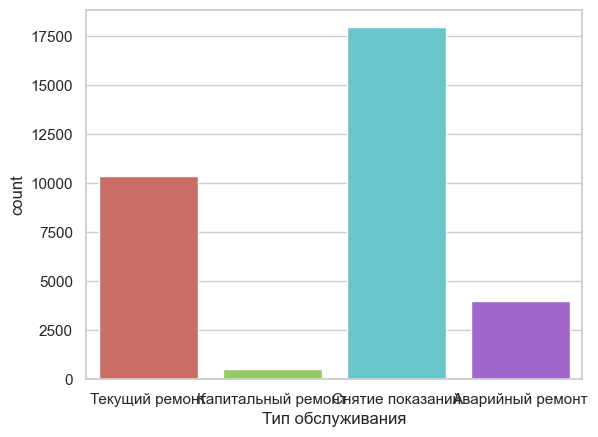

<Figure size 640x480 with 0 Axes>

In [5]:

agg_func_count = {'Наработка машины': ['count', 'nunique', 'mean']}
df1_1=df1.groupby(['Марка или обозначение техники','Инвентарный номер', 'Год'], as_index=False).agg(agg_func_count)

df1=df1.loc[(df1['Тип обслуживания'] == "Снятие показаний")|(df1['Тип обслуживания'] == "Капитальный ремонт")|(df1['Тип обслуживания'] == "Текущий ремонт")|(df1['Тип обслуживания'] == "Аварийный ремонт")]
df1=df1.loc[(df1['Тип машины'] == "Бульдозер")|(df1['Тип машины'] == "Самосвал карьерный")|(df1['Тип машины'] == "Буровой станок")|(df1['Тип машины'] == "Погрузчик")|(df1['Тип машины'] == "Экскаватор")]
df1.loc[:,"Наработка"]=df1.loc[:,"Наработка машины"]
df1=df1.sort_values(by=["Инвентарный номер",'Дата начала обслуживания'])
df1.reset_index(drop=True, inplace=True)
for i, row in df1.iterrows():
    if i>=1:
        if  (df1.loc[i,"Инвентарный номер"]==df1.loc[i-1,"Инвентарный номер"]):
            df1.loc[i,"Наработка"]=df1.loc[i,"Наработка машины"]-df1.loc[i-1,"Наработка машины"]
        else:
            df1.loc[i,"Наработка"]=0
    else:
            df1.loc[i,"Наработка"]=0
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

df1['Тип обслуживания'].value_counts()
sns.countplot(x='Тип обслуживания',data=df1, palette='hls')
plt.show()
plt.savefig('count_plot')

In [ ]:
df1['День'] = df1['Дата начала обслуживания'].dt.day

In [6]:
i=0
for i, row in df1.iterrows():
    if i>=1:
        if  (df1.loc[i,"Инвентарный номер"]==df1.loc[i-1,"Инвентарный номер"])&(df1.loc[i,"Дата начала обслуживания"]!=df1.loc[i-1,"Дата начала обслуживания"]):
            if  (df1.loc[i,"Тип обслуживания"]=='Снятие показаний'):
                df1.loc[i,"Ремонт"]=0
            if  ((df1.loc[i,"Тип обслуживания"]=='Текущий ремонт')or(df1.loc[i,"Тип обслуживания"]=='Капитальный ремонт')or(df1.loc[i,"Тип обслуживания"]=='Аварийный ремонт')):
                df1.loc[i,"Ремонт"]=1
        else:
                df1.loc[i,"Ремонт"]=2
    if i==0:
         if  (df1.loc[i,"Тип обслуживания"]=='Снятие показаний'):
             df1.loc[i,"Ремонт"]=0
         if  ((df1.loc[i,"Тип обслуживания"]=='Текущий ремонт')or(df1.loc[i,"Тип обслуживания"]=='Капитальный ремонт')or(df1.loc[i,"Тип обслуживания"]=='Аварийный ремонт')):

             df1.loc[i,"Ремонт"]=1

df2=df1
df1=df1.loc[(df1['Ремонт'] != 2)]

In [7]:
df1['Ремонт'].unique()

array([1., 0.])

In [8]:
count_sub_train=df1.loc[(df1['Дата начала обслуживания'] <='2022-04-01')]

In [9]:
count_sub_train

,Год,Месяц,Подразделение,Тип машины,Марка или обозначение техники,Модификация,Инвентарный номер,Дата начала обслуживания,Дата окончания обслуживания,Тип прибора учета работы,Показания прибора учета,Наработка машины,...,Должность ответственного,ФИО ответсвенного за установку,Дата установки запасной части,Группа деталей,"Наименование детали, материалов",Каталожный номер (Артикул),Единица измерения деталей,Количество деталей,Примечание,Отметка главного механика о проверке,Наработка,Ремонт
0,2020,Февраль,Эрел,Бульдозер,Т-130,0,112.0,2020-02-27,2020-02-27,Мотосчётчик,NaN,NaN,...,Старший механик,Байгужин Р.Ф.,2020-02-27 00:00:00,Двигатель,Масло моторное,М-10ДМ,л.,20.0,NaN,Проверено,0.0,1.0
4,2020,Март,Эрел,Бульдозер,Т-130,0,112.0,2020-03-07,2020-03-07,Мотосчётчик,NaN,NaN,...,Старший механик,Байгужин Р.Ф.,2020-03-07 00:00:00,Двигатель,"Насос водяной 16-08-140СП,",16-08-140СП,шт.,1.0,NaN,Проверено,NaN,1.0
7,2020,Март,Эрел,Бульдозер,Т-130,0,112.0,2020-03-26,2020-03-26,Мотосчётчик,NaN,NaN,...,Старший механик,Байгужин Р.Ф.,2020-03-26 00:00:00,Двигатель,Масло моторное,М-10ДМ,л.,20.0,NaN,Проверено,NaN,1.0
8,2020,Март,Эрел,Бульдозер,Т-130,0,112.0,2020-03-30,2020-03-30,Мотосчётчик,NaN,NaN,...,Старший механик,Каранин А.Б.,2020-03-30 00:00:00,Гидросистема,"Рукав высокого давления Н.036.85.03.170-01,",Н.036.85.03.170-01,шт.,2.0,NaN,Проверено,NaN,1.0
10,2020,Апрель,Эрел,Бульдозер,Т-130,0,112.0,2020-04-03,2020-04-19,Мотосчётчик,NaN,NaN,...,Старший механик,Каранин А.Б.,2020-04-04 00:00:00,Двигатель,Трубка,2218,шт.,16.0,NaN,Проверено,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32737,2020,Октябрь,Талынья,Экскаватор,PC-400,7,1166.0,2020-10-05,2020-10-05,Мотосчётчик,16895.0,16895.0,...,Старший механик,Хаитов А.Б.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Проверено,0.0,0.0
32738,2020,Октябрь,Талынья,Экскаватор,PC-400,7,1166.0,2020-10-12,2020-10-12,Мотосчётчик,16895.0,16895.0,...,Старший механик,Хаитов А.Б.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Проверено,0.0,0.0
32739,2020,Октябрь,Талынья,Экскаватор,PC-400,7,1166.0,2020-10-19,2020-10-19,Мотосчётчик,16895.0,16895.0,...,Старший механик,Хаитов А.Б.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Проверено,0.0,0.0
32740,2020,Октябрь,Талынья,Экскаватор,PC-400,7,1166.0,2020-10-26,2020-10-26,Мотосчётчик,16895.0,16895.0,...,Старший механик,Хаитов А.Б.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Проверено,0.0,0.0


In [10]:
count_sub_train=count_sub_train[count_sub_train['Инвентарный номер'] != 674]
train_fith=count_sub_train.iloc[:,count_sub_train.columns != 'Тип обслуживания']

In [11]:
train_fith.columns

Index(['Год', 'Месяц', 'Подразделение', 'Тип машины',
       'Марка или обозначение техники', 'Модификация', 'Инвентарный номер',
       'Дата начала обслуживания', 'Дата окончания обслуживания',
       'Тип прибора учета работы', 'Показания прибора учета',
       'Наработка машины', 'Состояние прибора учета', 'ФИО ответственного',
       'Должность ответственного', 'ФИО ответсвенного за установку',
       'Дата установки запасной части', 'Группа деталей',
       'Наименование детали, материалов', 'Каталожный номер (Артикул)',
       'Единица измерения деталей', 'Количество деталей', 'Примечание',
       'Отметка главного механика о проверке', 'Наработка', 'Ремонт'],
      dtype='object')

In [12]:
train_fith['ФИО ответственного'].unique()

array(['Шевченко С.С.', 'Подоляко В.Л.', 'Еремеев В.А.', 'Усачев А.И.',
       'Хаитов А.Б.', 'Андрийко В.А.', 'Тесленко В.В.', 'Савин Е.А.',
       'Хасанов Р.Н.', 'Гарнага В.С.', 'Русов С.Н.', 'Скориков А.Ю.',
       'Мороз Г.Г.', 'Никушев С.С.', 'Леонтьев С.В.'], dtype=object)

In [13]:
train_fith['ФИО ответственного'] = train_fith['ФИО ответственного'].replace(['Шевченко С.С.', 'Подоляко В.Л.', 'Еремеев В.А.', 'Усачев А.И.',
       'Мороз Г.Г.', 'Хаитов А.Б.', 'Андрийко В.А.', 'Тесленко В.В.',
       'Савин Е.А.', 'Леонтьев С.В.', 'Хасанов Р.Н.', 'Гарнага В.С.',
       'Русов С.Н.', 'Скориков А.Ю.', 'Никушев С.С.'], [1,
2,
3,
4,
5,
6,
7,
8,
9,
10,
11,
12,
13,
14,
15
])

C:\Users\poisk-12\AppData\Local\Temp\ipykernel_9424\3734195601.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_fith['ФИО ответственного'] = train_fith['ФИО ответственного'].replace(['Шевченко С.С.', 'Подоляко В.Л.', 'Еремеев В.А.', 'Усачев А.И.',


C:\Users\poisk-12\AppData\Local\Temp\ipykernel_9424\1121269238.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_fith['Подразделение'] = train_fith['Подразделение'].replace(['Талынья', 'Большой Тарын', 'Тарын', 'Эрел', 'Айхал',
C:\Users\poisk-12\AppData\Local\Temp\ipykernel_9424\1121269238.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_fith['Тип машины'] = train_fith['Тип машины'].  replace([ 'Автозаправщик', 'Бульдозер', 'Легковой транспорт',


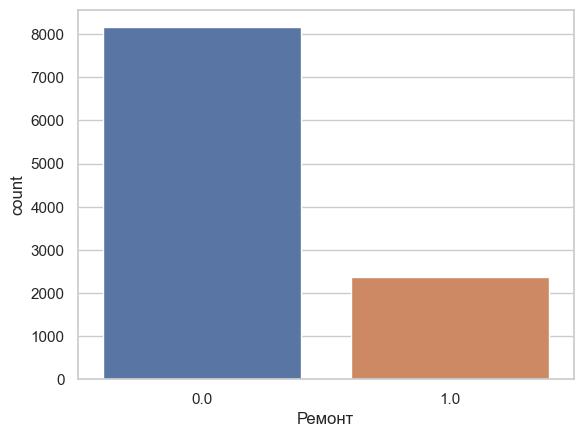

In [14]:
sb.countplot(x='Ремонт', data=train_fith)
#log_reg = LogisticRegression()
train_fith['Подразделение'].unique ()
train_fith['Подразделение'] = train_fith['Подразделение'].replace(['Талынья', 'Большой Тарын', 'Тарын', 'Эрел', 'Айхал',
       'Малый Тарын', 'АТП', 'Сайлык', 'Келлям', 'Калы-Кыс'], [1, 2,3,4,5,6,7,8,9,10])
train_fith['Тип машины'].unique ()
train_fith['Тип машины'] = train_fith['Тип машины'].  replace([ 'Автозаправщик', 'Бульдозер', 'Легковой транспорт',
'Грузовой транспорт', 'Промприбор', 'Водный транспорт',
'Самосвал карьерный', 'ДЭС', 'Автобус', 'Погрузчик вилочный',
'Буровой станок', 'Автокран', 'Прочее', 'Погрузчик',
'Зарадная установка', 'Экскаватор', 'Насосная станция',
'Водовозка'], [1, 2, 3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18])

In [15]:
train_fith['Группа деталей'].unique ()

array(['Двигатель', 'Гидросистема', 'Трансмиссия', 'Рабочее оборудование',
       'Ходовая часть', nan, 'Рулевое управление', 'Тормозная система',
       'Компрессор', 'Кузов', 'Поворотная платформа', 'Рама',
       'Двигатель ', 'Буровое оборудование', 'Электрооборудование ',
       'Навесное оборудование', 'Ходовая', 'Электрооборудование',
       'кабина', 'Навесное ', 'Инструмент', 'бензопила', 'Ходовая ',
       'Гиросистема', 'Ходовая часть ', 'Насосоное оборудование',
       'Кабина', 'Электооборудование', 'Кабина ', ' Ходовая', 'Навесное'],
      dtype=object)

In [16]:
train_fith['Группа деталей'] = train_fith['Группа деталей'].  replace([ 'Двигатель', 'Гидросистема', 'Трансмиссия', 'Рабочее оборудование',
       'Ходовая часть', 'Рулевое управление', 'Тормозная система',
       'Компрессор', 'Кузов', 'Поворотная платформа', 'Рама',
       'Навесное оборудование', 'Двигатель ', 'Буровое оборудование',
       'Электрооборудование ', 'Ходовая', 'Электрооборудование', 'кабина',
       'Навесное ', 'Инструмент', 'бензопила', 'Ходовая ', 'Гиросистема',
       'Ходовая часть ', 'Насосоное оборудование', 'Гидравлика', 'Кабина',
       'Электооборудование', 'Кабина ', ' Ходовая', 'Навесное',
       'Пневмосистема', 'Буровое оборудлвание'], [1, 2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33])

C:\Users\poisk-12\AppData\Local\Temp\ipykernel_9424\129851070.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_fith['Группа деталей'] = train_fith['Группа деталей'].  replace([ 'Двигатель', 'Гидросистема', 'Трансмиссия', 'Рабочее оборудование',


In [17]:
train_fith.dtypes

Год                                       int64
Месяц                                    object
Подразделение                            object
Тип машины                                int64
Марка или обозначение техники            object
                                         ...   
Количество деталей                      float64
Примечание                               object
Отметка главного механика о проверке     object
Наработка                               float64
Ремонт                                  float64
Length: 26, dtype: object

In [18]:
train_fith['Дата начала обслуживания'] = pd.to_datetime(train_fith['Дата начала обслуживания'])

C:\Users\poisk-12\AppData\Local\Temp\ipykernel_9424\1009850804.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_fith['Дата начала обслуживания'] = pd.to_datetime(train_fith['Дата начала обслуживания'])


In [19]:
train_fith.columns

Index(['Год', 'Месяц', 'Подразделение', 'Тип машины',
       'Марка или обозначение техники', 'Модификация', 'Инвентарный номер',
       'Дата начала обслуживания', 'Дата окончания обслуживания',
       'Тип прибора учета работы', 'Показания прибора учета',
       'Наработка машины', 'Состояние прибора учета', 'ФИО ответственного',
       'Должность ответственного', 'ФИО ответсвенного за установку',
       'Дата установки запасной части', 'Группа деталей',
       'Наименование детали, материалов', 'Каталожный номер (Артикул)',
       'Единица измерения деталей', 'Количество деталей', 'Примечание',
       'Отметка главного механика о проверке', 'Наработка', 'Ремонт'],
      dtype='object')

In [20]:
train_fith = train_fith.drop(columns=['Группа деталей','Марка или обозначение техники','Состояние прибора учета','Дата начала обслуживания','Дата окончания обслуживания','Модификация','Инвентарный номер','Тип прибора учета работы','Подразделение',
       'Должность ответственного', 'ФИО ответсвенного за установку',
       'Дата установки запасной части', 'Группа деталей',
       'Наименование детали, материалов', 'Каталожный номер (Артикул)',
       'Единица измерения деталей', 'Количество деталей', 'Примечание',
       'Отметка главного механика о проверке'])
train_fith['Месяц'] = train_fith['Месяц'].  replace([ 'Январь', 'Февраль','Март', 'Апрель', 'Май', 'Июнь', 'Июль', 'Август', 'Сентябрь','Октябрь','Ноябрь', 'Декабрь'], [1, 2,3,4,5,6,7,8,9,10,11,12])
train_fith= train_fith.fillna(0)

In [21]:
train_fith.head()

,Год,Месяц,Тип машины,Показания прибора учета,Наработка машины,ФИО ответственного,Наработка,Ремонт
0,2020,2,2,0.0,0.0,1,0.0,1.0
4,2020,3,2,0.0,0.0,1,0.0,1.0
7,2020,3,2,0.0,0.0,1,0.0,1.0
8,2020,3,2,0.0,0.0,1,0.0,1.0
10,2020,4,2,0.0,0.0,1,0.0,1.0


In [22]:
df_train=train_fith.sample(frac=0.7)

In [23]:
df_test=df1.loc[(df1['Дата начала обслуживания'] > '2022-04-01')]

In [24]:
df_train

,Год,Месяц,Тип машины,Показания прибора учета,Наработка машины,ФИО ответственного,Наработка,Ремонт
14333,2022,2,2,10826.0,10826.0,13,0.0,0.0
29384,2021,5,7,25007.0,25007.0,3,96.0,0.0
22992,2021,7,11,271.0,271.0,1,0.0,0.0
10880,2021,5,7,8716.0,8716.0,3,131.0,0.0
13535,2020,10,2,19846.0,19846.0,6,0.0,0.0
...,...,...,...,...,...,...,...,...
3394,2020,5,7,12950.0,12950.0,11,0.0,0.0
1558,2020,7,7,13850.0,13850.0,3,0.0,0.0
15713,2021,3,7,9421.0,9421.0,3,0.0,0.0
19340,2021,8,7,4887.0,4887.0,2,132.0,0.0


In [25]:
!pip install --pre pycaret

In [64]:
data=df_train
from pycaret.classification import *
#from pycaret.regression import *
data.describe()
clf = setup(data, target = "Ремонт",session_id = 1, normalize=1)

In [65]:
models()

,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsCl...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDC...,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,sklearn.neural_network._multilayer_perceptron....,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


Создадим и обучим модели.
- Accuracy - вероятность
- AUC Значение AUC может находиться в диапазоне от 0 до 1, где значение 0 означает, что модель классифицирует все объекты неправильно, а значение 1 означает, что модель классифицирует все объекты правильно. Чем выше значение AUC, тем лучше модель классифицирует объекты.
- Recall- чувствительность. это метрика качества в задачах классификации, которая описывает способность модели правильно классифицировать объекты положительного класса.Чувствительность показывает, насколько хорошо модель может идентифицировать объекты положительного класса
- Точность (precision) - это метрика оценки производительности классификатора, которая определяется как отношение числа правильно классифицированных положительных примеров (True Positives) к общему числу примеров. Например, если мы разрабатываем систему, которая определяет, является ли электронное письмо спамом, то ложноположительные решения могут привести к тому, что настоящие письма будут помечены как спам и не будут доставлены адресату, что может быть очень дорогостоящей ошибкой
- F-мера (F1-мера) - это гармоническое среднее между точностью (precision) и полнотой (recall) классификатора.


In [66]:
%%time
best_model = compare_models()

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,22:46:22
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


Processing:   0%|          | 0/61 [00:00<?, ?it/s]

CPU times: total: 1min 52s
Wall time: 1min 52s


In [67]:
lightgbm = create_model('lightgbm', cross_val=True)


,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,22:48:14
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [68]:
tuned_lightgbm=lightgbm


In [69]:
lightgbm = create_model('lightgbm')

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,22:48:39
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [70]:

lightgbm_calibration=calibrate_model(tuned_lightgbm)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,22:48:49
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

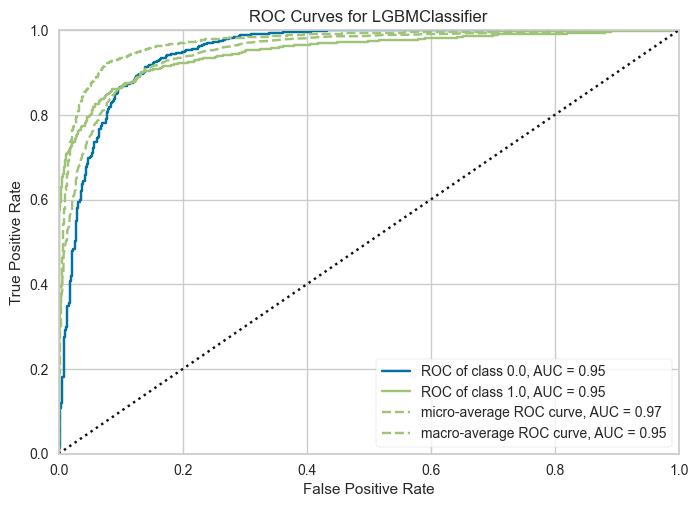

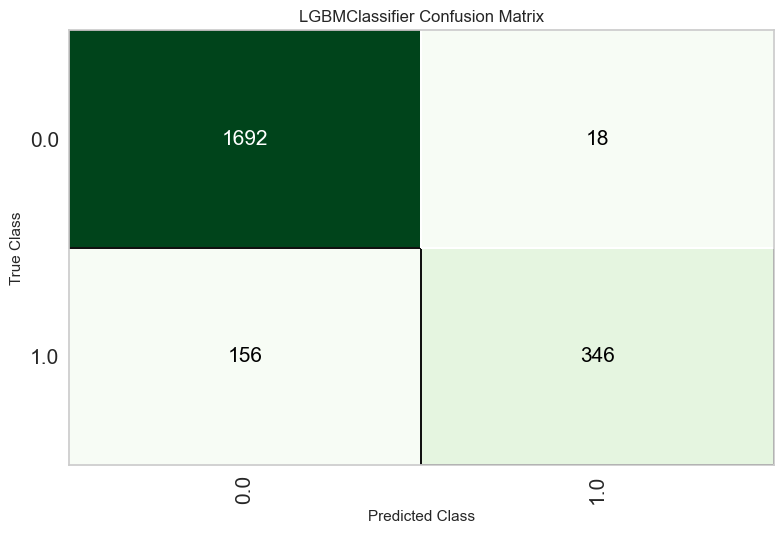

In [72]:
plot_model(tuned_lightgbm)
plot_model(tuned_lightgbm, plot = 'confusion_matrix')

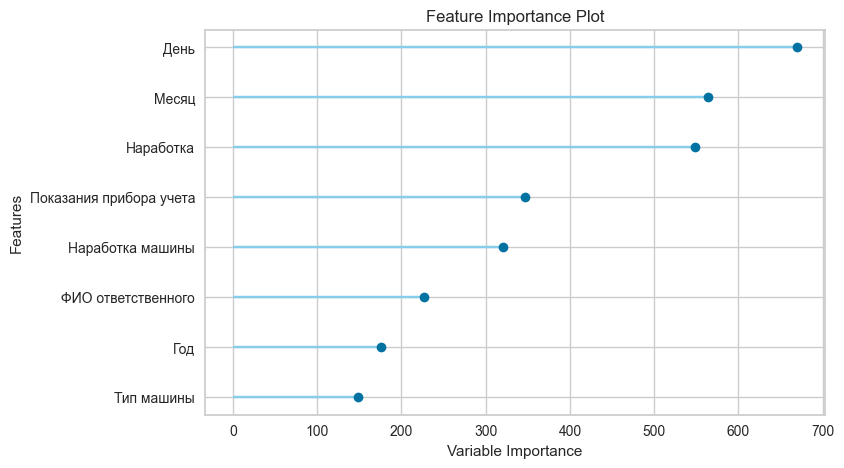

In [74]:
plot_model(tuned_lightgbm, plot = 'feature')

In [76]:
pred_holdouts = predict_model(tuned_lightgbm)
pred_holdouts

,Год,Месяц,Тип машины,Показания прибора учета,Наработка машины,ФИО ответственного,Наработка,День,Ремонт,prediction_label,prediction_score
3273,2021,10,7,9138.0,9138.0,2,42.0,6,1.0,0,0.8393
24436,2021,6,2,1287.0,1287.0,1,0.0,25,0.0,0,0.9633
20382,2021,6,16,5394.0,5394.0,6,96.0,19,1.0,0,0.9445
12834,2021,8,2,20305.0,20305.0,6,55.0,30,0.0,0,0.8103
8407,2020,10,2,13513.0,13513.0,6,0.0,19,0.0,0,0.9337
...,...,...,...,...,...,...,...,...,...,...,...
20394,2021,8,16,6629.0,6629.0,6,128.0,23,0.0,0,0.9883
17667,2021,9,2,18831.0,18831.0,11,46.0,20,0.0,0,0.7465
14743,2021,8,16,16444.0,16444.0,11,39.0,9,0.0,0,0.9304
2801,2020,6,7,9926.0,9926.0,2,0.0,15,0.0,0,0.9601


In [77]:
final_lightgbm=finalize_model(tuned_lightgbm)

In [78]:
predict_model(final_lightgbm);

In [79]:
df_test.dropna(subset=['Ремонт'], inplace=True)

In [80]:
df_test.head()

,Год,Месяц,Подразделение,Тип машины,Марка или обозначение техники,Модификация,Инвентарный номер,Дата начала обслуживания,Дата окончания обслуживания,Тип прибора учета работы,...,Группа деталей,"Наименование детали, материалов",Каталожный номер (Артикул),Единица измерения деталей,Количество деталей,Примечание,Отметка главного механика о проверке,Наработка,День,Ремонт
460,2022,Апрель,Талынья,Экскаватор,ЭКГ,5А,169.0,2022-04-27,2022-04-27,Мотосчётчик,...,Навесное оборудование,Зуб ковша,1080.02.10-1СБ,шт.,5.000,Требование № 71,Проверено,NaN,27,1.0
462,2022,Май,Талынья,Экскаватор,ЭКГ,5А,169.0,2022-05-03,2022-05-03,Мотосчётчик,...,Рабочее оборудование,Консистентная смазка,Смазка графитная,кг.,23.000,Требование № 84,Проверено,NaN,3,1.0
468,2022,Май,Талынья,Экскаватор,ЭКГ,5А,169.0,2022-05-16,2022-05-16,Мотосчётчик,...,Рабочее оборудование,Канат Ø39,NaN,км.,0.026,Требование № 133,Проверено,NaN,16,1.0
469,2022,Май,Талынья,Экскаватор,ЭКГ,5А,169.0,2022-05-20,2022-05-20,Мотосчётчик,...,Навесное оборудование,Зуб ковша,1080.02.10-1СБ,шт.,5.000,Требование № 121,Проверено,NaN,20,1.0
470,2022,Май,Талынья,Экскаватор,ЭКГ,5А,169.0,2022-05-29,2022-05-29,Мотосчётчик,...,Рабочее оборудование,Канат Ø39,NaN,км.,0.060,Требование № 137,Проверено,NaN,29,1.0


In [81]:
df_test['Тип машины'].unique ()

array(['Экскаватор', 'Буровой станок', 'Самосвал карьерный', 'Бульдозер',
       'Погрузчик'], dtype=object)

In [82]:

df_test['Тип машины'] = df_test['Тип машины'].  replace([ 'Автозаправщик', 'Бульдозер', 'Легковой транспорт',
'Грузовой транспорт', 'Промприбор', 'Водный транспорт',
'Самосвал карьерный', 'ДЭС', 'Автобус', 'Погрузчик вилочный',
'Буровой станок', 'Автокран', 'Прочее', 'Погрузчик',
'Зарадная установка', 'Экскаватор', 'Насосная станция',
'Водовозка'], [1, 2, 3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18])

In [83]:
df_test['Тип обслуживания'].unique()

array(['Текущий ремонт', 'Аварийный ремонт', 'Снятие показаний',
       'Капитальный ремонт'], dtype=object)

In [84]:
df_test['Тип обслуживания'] = df_test['Тип обслуживания'].  replace([ 'Текущий ремонт', 'Аварийный ремонт', 'Капитальный ремонт','Снятие показаний'], [1, 2, 3,4])

In [86]:
df_test['Месяц'] = df_test['Месяц'].  replace([ 'Январь', 'Февраль','Март', 'Апрель', 'Май', 'Июнь', 'Июль', 'Август', 'Сентябрь','Октябрь','Ноябрь', 'Декабрь'], [1, 2,3,4,5,6,7,8,9,10,11,12])
df_test= df_test.fillna(0)

In [87]:
df_test

,Год,Месяц,Подразделение,Тип машины,Марка или обозначение техники,Модификация,Инвентарный номер,Дата начала обслуживания,Дата окончания обслуживания,Тип прибора учета работы,...,Группа деталей,"Наименование детали, материалов",Каталожный номер (Артикул),Единица измерения деталей,Количество деталей,Примечание,Отметка главного механика о проверке,Наработка,День,Ремонт
460,2022,4,Талынья,16,ЭКГ,5А,169.0,2022-04-27,2022-04-27 00:00:00,Мотосчётчик,...,Навесное оборудование,Зуб ковша,1080.02.10-1СБ,шт.,5.000,Требование № 71,Проверено,0.0,27,1.0
462,2022,5,Талынья,16,ЭКГ,5А,169.0,2022-05-03,2022-05-03 00:00:00,Мотосчётчик,...,Рабочее оборудование,Консистентная смазка,Смазка графитная,кг.,23.000,Требование № 84,Проверено,0.0,3,1.0
468,2022,5,Талынья,16,ЭКГ,5А,169.0,2022-05-16,2022-05-16 00:00:00,Мотосчётчик,...,Рабочее оборудование,Канат Ø39,0,км.,0.026,Требование № 133,Проверено,0.0,16,1.0
469,2022,5,Талынья,16,ЭКГ,5А,169.0,2022-05-20,2022-05-20 00:00:00,Мотосчётчик,...,Навесное оборудование,Зуб ковша,1080.02.10-1СБ,шт.,5.000,Требование № 121,Проверено,0.0,20,1.0
470,2022,5,Талынья,16,ЭКГ,5А,169.0,2022-05-29,2022-05-29 00:00:00,Мотосчётчик,...,Рабочее оборудование,Канат Ø39,0,км.,0.060,Требование № 137,Проверено,0.0,29,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32684,2023,6,Талынья,16,PC-750,7,1162.0,2023-06-22,2023-06-22 00:00:00,Мотосчётчик,...,0,0,0,0,0.000,0,0,0.0,22,0.0
32685,2023,8,Талынья,16,PC-750,7,1162.0,2023-08-21,2023-08-21 00:00:00,Мотосчётчик,...,0,0,0,0,0.000,0,0,0.0,21,0.0
32686,2023,8,Талынья,16,PC-750,7,1162.0,2023-08-24,2023-08-24 00:00:00,Мотосчётчик,...,0,0,0,0,0.000,0,0,0.0,24,0.0
32687,2023,8,Талынья,16,PC-750,7,1162.0,2023-08-28,2023-08-28 00:00:00,Мотосчётчик,...,0,0,0,0,0.000,0,0,0.0,28,0.0


In [109]:
df_test['ФИО ответственного'] = df_test['ФИО ответственного'].replace(['Шевченко С.С.', 'Подоляко В.Л.', 'Еремеев В.А.', 'Усачев А.И.',
       'Мороз Г.Г.', 'Хаитов А.Б.', 'Андрийко В.А.', 'Тесленко В.В.',
       'Савин Е.А.', 'Леонтьев С.В.', 'Хасанов Р.Н.', 'Гарнага В.С.',
       'Русов С.Н.', 'Скориков А.Ю.', 'Никушев С.С.','Малюк В.В.','Довгаль С.В.','Давыдов М.А.', 'Кутовой А.Ю.','Ольховой А.А.', 'Бородин А.В.','Кузьмина О.Л.','Якубец В.Г.','Москаленко В.Т.','Носков В.И.','Калюга Н.С.'], [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26])

In [110]:
unseen_predictions=predict_model(final_lightgbm, data=df_test)

In [111]:

unseen_predictions

,Год,Месяц,Подразделение,Тип машины,Марка или обозначение техники,Модификация,Инвентарный номер,Дата начала обслуживания,Дата окончания обслуживания,Тип прибора учета работы,...,Каталожный номер (Артикул),Единица измерения деталей,Количество деталей,Примечание,Отметка главного механика о проверке,Наработка,День,Ремонт,prediction_label,prediction_score
460,2022,4,Талынья,16,ЭКГ,5А,169.0,2022-04-27,2022-04-27 00:00:00,Мотосчётчик,...,1080.02.10-1СБ,шт.,5.000,Требование № 71,Проверено,0.0,27,1.0,1,0.9939
462,2022,5,Талынья,16,ЭКГ,5А,169.0,2022-05-03,2022-05-03 00:00:00,Мотосчётчик,...,Смазка графитная,кг.,23.000,Требование № 84,Проверено,0.0,3,1.0,1,0.9926
468,2022,5,Талынья,16,ЭКГ,5А,169.0,2022-05-16,2022-05-16 00:00:00,Мотосчётчик,...,0,км.,0.026,Требование № 133,Проверено,0.0,16,1.0,1,0.9964
469,2022,5,Талынья,16,ЭКГ,5А,169.0,2022-05-20,2022-05-20 00:00:00,Мотосчётчик,...,1080.02.10-1СБ,шт.,5.000,Требование № 121,Проверено,0.0,20,1.0,1,0.9958
470,2022,5,Талынья,16,ЭКГ,5А,169.0,2022-05-29,2022-05-29 00:00:00,Мотосчётчик,...,0,км.,0.060,Требование № 137,Проверено,0.0,29,1.0,1,0.9974
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32684,2023,6,Талынья,16,PC-750,7,1162.0,2023-06-22,2023-06-22 00:00:00,Мотосчётчик,...,0,0,0.000,0,0,0.0,22,0.0,0,0.7122
32685,2023,8,Талынья,16,PC-750,7,1162.0,2023-08-21,2023-08-21 00:00:00,Мотосчётчик,...,0,0,0.000,0,0,0.0,21,0.0,0,0.8776
32686,2023,8,Талынья,16,PC-750,7,1162.0,2023-08-24,2023-08-24 00:00:00,Мотосчётчик,...,0,0,0.000,0,0,0.0,24,0.0,0,0.6179
32687,2023,8,Талынья,16,PC-750,7,1162.0,2023-08-28,2023-08-28 00:00:00,Мотосчётчик,...,0,0,0.000,0,0,0.0,28,0.0,0,0.6693


In [112]:
unseen_predictions['Тип машины'].unique ()
unseen_predictions['Тип машины'] = unseen_predictions['Тип машины'].  replace([1, 2, 3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18],[ 'Автозаправщик', 'Бульдозер', 'Легковой транспорт',
'Грузовой транспорт', 'Промприбор', 'Водный транспорт',
'Самосвал карьерный', 'ДЭС', 'Автобус', 'Погрузчик вилочный',
'Буровой станок', 'Автокран', 'Прочее', 'Погрузчик',
'Зарадная установка', 'Экскаватор', 'Насосная станция',
'Водовозка'])

unseen_predictions['Месяц'] = unseen_predictions['Месяц'].  replace([1, 2,3,4,5,6,7,8,9,10,11,12],[ 'Январь', 'Февраль','Март', 'Апрель', 'Май', 'Июнь', 'Июль', 'Август', 'Сентябрь', 'Октябрь', 'Ноябрь', 'Декабрь'])

In [113]:
unseen_predictions['Тип обслуживания'].unique()

array([1, 2, 4, 3], dtype=int8)

In [114]:
unseen_predictions['Тип обслуживания'] = unseen_predictions['Тип обслуживания'].  replace([1, 2, 3,4], [ 'Текущий ремонт', 'Аварийный ремонт', 'Капитальный ремонт','Снятие показаний'])

In [116]:
unseen_predictions['ФИО ответственного'] =unseen_predictions['ФИО ответственного'].replace(  [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26]
,['Шевченко С.С.', 'Подоляко В.Л.', 'Еремеев В.А.', 'Усачев А.И.',
       'Мороз Г.Г.', 'Хаитов А.Б.', 'Андрийко В.А.', 'Тесленко В.В.',
       'Савин Е.А.', 'Леонтьев С.В.', 'Хасанов Р.Н.', 'Гарнага В.С.',
       'Русов С.Н.', 'Скориков А.Ю.', 'Никушев С.С.','Малюк В.В.','Довгаль С.В.','Давыдов М.А.', 'Кутовой А.Ю.','Ольховой А.А.', 'Бородин А.В.','Кузьмина О.Л.','Якубец В.Г.','Москаленко В.Т.','Носков В.И.','Калюга Н.С.'])

In [117]:
unseen_predictions.loc[(unseen_predictions["Инвентарный номер"]==1091)]

,Год,Месяц,Подразделение,Тип машины,Марка или обозначение техники,Модификация,Инвентарный номер,Дата начала обслуживания,Дата окончания обслуживания,Тип прибора учета работы,...,Каталожный номер (Артикул),Единица измерения деталей,Количество деталей,Примечание,Отметка главного механика о проверке,Наработка,День,Ремонт,prediction_label,prediction_score
25890,2022,Апрель,Айхал,Буровой станок,JD-2000,0,1091.0,2022-04-25,2022-04-25 00:00:00,Мотосчётчик,...,0,0,0.0,0,Проверено,129.0,25,0.0,0,0.9682
25891,2022,Май,Сайлык,Буровой станок,JD-2000,0,1091.0,2022-05-02,2022-05-02 00:00:00,Мотосчётчик,...,0,0,0.0,0,Проверено,0.0,2,0.0,0,0.9871
25892,2022,Май,Сайлык,Буровой станок,JD-2000,0,1091.0,2022-05-09,2022-05-09 00:00:00,Мотосчётчик,...,0,0,0.0,0,Проверено,0.0,9,0.0,0,0.9807
25893,2022,Май,Сайлык,Буровой станок,JD-2000,0,1091.0,2022-05-16,2022-05-16 00:00:00,Мотосчётчик,...,0,0,0.0,0,Проверено,0.0,16,0.0,0,0.9813
25894,2022,Май,Сайлык,Буровой станок,JD-2000,0,1091.0,2022-05-23,2022-05-23 00:00:00,Мотосчётчик,...,0,0,0.0,0,Проверено,0.0,23,0.0,0,0.9881
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25969,2023,Август,Дражный,Буровой станок,JD-2000,0,1091.0,2023-08-17,2023-08-17 00:00:00,Мотосчётчик,...,0,0,0.0,0,0,0.0,17,0.0,0,0.9763
25970,2023,Август,Дражный,Буровой станок,JD-2000,0,1091.0,2023-08-21,2023-08-21 00:00:00,Мотосчётчик,...,0,0,0.0,0,0,0.0,21,0.0,0,0.9584
25971,2023,Август,Дражный,Буровой станок,JD-2000,0,1091.0,2023-08-24,2023-08-24 00:00:00,Мотосчётчик,...,0,0,0.0,0,0,0.0,24,0.0,0,0.9698
25972,2023,Август,Дражный,Буровой станок,JD-2000,0,1091.0,2023-08-28,2023-08-28 00:00:00,Мотосчётчик,...,0,0,0.0,0,0,0.0,28,0.0,0,0.9409


In [118]:
df=unseen_predictions

In [119]:
unseen_predictions.dtypes

Год                                              int32
Месяц                                           object
Подразделение                                 category
Тип машины                                      object
Марка или обозначение техники                 category
Модификация                                   category
Инвентарный номер                              float32
Дата начала обслуживания                datetime64[ns]
Дата окончания обслуживания                   category
Тип прибора учета работы                      category
Показания прибора учета                        float32
Наработка машины                               float32
Состояние прибора учета                       category
Тип обслуживания                                object
ФИО ответственного                              object
Должность ответственного                      category
ФИО ответсвенного за установку                category
Дата установки запасной части                 category
Группа дет

In [120]:
df['Дата начала обслуживания'] = pd.to_datetime(df['Дата начала обслуживания'])

In [121]:
df.dtypes

Год                                              int32
Месяц                                           object
Подразделение                                 category
Тип машины                                      object
Марка или обозначение техники                 category
Модификация                                   category
Инвентарный номер                              float32
Дата начала обслуживания                datetime64[ns]
Дата окончания обслуживания                   category
Тип прибора учета работы                      category
Показания прибора учета                        float32
Наработка машины                               float32
Состояние прибора учета                       category
Тип обслуживания                                object
ФИО ответственного                              object
Должность ответственного                      category
ФИО ответсвенного за установку                category
Дата установки запасной части                 category
Группа дет

In [122]:
df['Номер недели'] = df['Дата начала обслуживания'].dt.week

In [123]:
df.head()

,Год,Месяц,Подразделение,Тип машины,Марка или обозначение техники,Модификация,Инвентарный номер,Дата начала обслуживания,Дата окончания обслуживания,Тип прибора учета работы,...,Единица измерения деталей,Количество деталей,Примечание,Отметка главного механика о проверке,Наработка,День,Ремонт,prediction_label,prediction_score,Номер недели
460,2022,Апрель,Талынья,Экскаватор,ЭКГ,5А,169.0,2022-04-27,2022-04-27 00:00:00,Мотосчётчик,...,шт.,5.000,Требование № 71,Проверено,0.0,27,1.0,1,0.9939,17
462,2022,Май,Талынья,Экскаватор,ЭКГ,5А,169.0,2022-05-03,2022-05-03 00:00:00,Мотосчётчик,...,кг.,23.000,Требование № 84,Проверено,0.0,3,1.0,1,0.9926,18
468,2022,Май,Талынья,Экскаватор,ЭКГ,5А,169.0,2022-05-16,2022-05-16 00:00:00,Мотосчётчик,...,км.,0.026,Требование № 133,Проверено,0.0,16,1.0,1,0.9964,20
469,2022,Май,Талынья,Экскаватор,ЭКГ,5А,169.0,2022-05-20,2022-05-20 00:00:00,Мотосчётчик,...,шт.,5.000,Требование № 121,Проверено,0.0,20,1.0,1,0.9958,20
470,2022,Май,Талынья,Экскаватор,ЭКГ,5А,169.0,2022-05-29,2022-05-29 00:00:00,Мотосчётчик,...,км.,0.060,Требование № 137,Проверено,0.0,29,1.0,1,0.9974,21


In [124]:
df.to_excel(os.path.join(current_dir, 'df.xlsx'), index=True)